Что сделать?
+ импортировать(!!!), установив свой пакет мутспек в био-енв, класс для парсинга кодонов
+ залить туда функцию парсинга генбанка
+ заменить глупые is_syn & is_ff на стандартный лейбл, там лежит функция ~ get_mut_type
+ получить частоты тринуклеотидов и нуклеотидов простым подсчетом из Ref таблицы
+ воспользоваться уже написанной функцией подсчета мутспека. Ее нужно подправить - добавить вариант когда нужно считать дискретные состояния, а не вероятности, еще один аргумент
+ развернуть мутспек потому что он опять посчитан на L цепи, а надо перевести в H

- Поделить на H & L
- Разложить на подписи

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial

from mutspec.utils import (
    read_genbank_ref, calculate_mutspec, CodonAnnotation, 
    possible_codons, possible_sbs12, possible_sbs192,
)
from mutspec.utils.annot import mutations_summary, translator, rev_comp, lbl2lbl_id, lbl_id2lbl

sns.set_style()
from mutspec.utils.draw import plot_mutspec12, plot_mutspec192

## Observed mutations

In [2]:
mutations = pd.read_csv("../data/processed/mutations.csv")
print(mutations.shape)
mutations.head()

(7611, 16)


,tissue,TurnOverDays,tumor_var_freq,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS,AltCodon,Label,Mut
0,Bladder,200.0,38.7900,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
1,Pancreas,360.0,21.0500,2680,T,TTG,1,rRNA,RNR2,-1,-1,NaN,10487.0,NaN,0,T[T>C]G
2,Bladder,200.0,10.1400,6011,T,TTA,1,CDS,COX1,108,3,CTT,426.0,CTC,2,T[T>C]A
3,Bladder,200.0,37.3900,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C
4,Esophagus,11.0,0.7013,7706,G,TGC,1,CDS,COX2,121,1,GCC,3816.0,ACC,0,T[G>A]C


## Expected mutations

In [3]:
with open("../data/processed/expected_sbs192.json") as handle:
    exp_muts192 = json.load(handle)
with open("../data/processed/expected_sbs12.json") as handle:
    exp_muts12 = json.load(handle)

In [4]:
pd.DataFrame(exp_muts12).sort_index()

,ff,syn,all,allCYTB,D-loop,rRNA,tRNA,ExDloop
A>C,766,766,3148,325,339,861,527,4785
A>G,766,1308,3148,325,339,861,527,4785
A>T,766,766,3148,325,339,861,527,4785
C>A,817,817,3579,390,371,650,353,4810
C>G,817,817,3579,390,371,650,353,4810
C>T,817,1872,3579,390,371,650,353,4810
G>A,96,178,1294,137,150,451,217,2015
G>C,96,96,1294,137,150,451,217,2015
G>T,96,96,1294,137,150,451,217,2015
T>A,261,261,2758,286,260,548,405,3834


In [5]:
pd.DataFrame(exp_muts192).sort_index()

,ff,syn,all,allCYTB,D-loop,rRNA,tRNA,ExDloop
A[A>C]A,NaN,NaN,265,25.0,30,113,78.0,494
A[A>C]C,NaN,NaN,304,27.0,32,84,51.0,463
A[A>C]G,NaN,NaN,81,6.0,13,69,40.0,196
A[A>C]T,NaN,NaN,233,32.0,21,50,41.0,355
A[A>G]A,NaN,78.0,265,25.0,30,113,78.0,494
...,...,...,...,...,...,...,...,...
T[T>C]T,13.0,47.0,153,11.0,20,32,44.0,231
T[T>G]A,34.0,34.0,192,19.0,18,56,52.0,311
T[T>G]C,28.0,28.0,232,28.0,15,26,27.0,293
T[T>G]G,11.0,11.0,65,10.0,12,22,14.0,104


## Calculate mutspec

In [6]:
MutCDS = mutations[(mutations.Type == "CDS") & (mutations.Strand == 1) & (mutations.Label >= 0)]
mutspec192 = pd.DataFrame({"Mut": possible_sbs192})

for lbl in exp_muts192:
    if lbl in {"all", "syn", "ff"}:
        ms192 = calculate_mutspec(MutCDS[MutCDS.Label >= lbl2lbl_id(lbl)], exp_muts192[lbl], use_context=True, use_proba=False)

    elif lbl == "allCYTB":
        MutCYTBall = mutations[(mutations.GeneName == "CYTB")]
        ms192 = calculate_mutspec(MutCYTBall, exp_muts192[lbl], use_context=True, use_proba=False)

    elif lbl == "ExDloop":
        _MutExDloop = mutations[(mutations.Type != "D-loop")]  # & (mutations.Label >= 0) & (mutations.Strand == 1)
        ms192 = calculate_mutspec(_MutExDloop, exp_muts192[lbl], use_context=True, use_proba=False)
        ms12 = calculate_mutspec(_MutExDloop, exp_muts12[lbl], use_context=False, use_proba=False)

    else:
        MutCustom = mutations[(mutations.Type == lbl)]
        ms192 = calculate_mutspec(MutCustom, exp_muts192[lbl], use_context=True, use_proba=False)

    ms192.rename({"MutSpec": f"MutSpec_{lbl}"}, axis=1, inplace=True)
    mutspec192 = pd.merge(mutspec192, ms192[["Mut", f"MutSpec_{lbl}"]], on="Mut")

# Reverse complement of Mut (to heavy strand)
mutspec192["Mut"] = mutspec192.Mut.apply(rev_comp)
ms12["Mut"] = ms12["Mut"].str.translate(translator)
mutspec192.sort_values("Mut", inplace=True)

In [7]:
mutspec192.to_csv("../data/processed/cancer_mutspec.csv", index=None)
mutspec192

,Mut,MutSpec_ff,MutSpec_syn,MutSpec_all,MutSpec_allCYTB,MutSpec_D-loop,MutSpec_rRNA,MutSpec_tRNA,MutSpec_ExDloop
191,A[A>C]A,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
187,A[A>C]C,0.000000,0.000000,0.001163,0.000000,0.000000,0.000681,0.000000,0.000741
183,A[A>C]G,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
179,A[A>C]T,0.000000,0.000000,0.000118,0.000000,0.000000,0.000000,0.000000,0.000080
175,A[A>G]A,0.012382,0.006190,0.008917,0.008524,0.004811,0.008852,0.006236,0.007838
...,...,...,...,...,...,...,...,...,...
16,T[T>C]T,0.000000,0.000339,0.000303,0.000000,0.000535,0.000386,0.000704,0.000545
12,T[T>G]A,0.000000,0.000000,0.000235,0.001875,0.000000,0.000000,0.000000,0.000126
8,T[T>G]C,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,T[T>G]G,0.000322,0.000264,0.001534,0.000000,0.003007,0.000000,0.001168,0.001017


### Count similarities
Without missing data

In [8]:
coda = CodonAnnotation(2)

In [9]:
print("Excluding zeros (missing observations)\n")
print("Labels  \t\tCos_sim192\tEucDist192")
print("-" * 50)
_lbls = set()
for lbl1 in exp_muts192:
    _lbls.add(lbl1)
    for lbl2 in exp_muts192:
        if lbl1 != lbl2 and lbl2 not in _lbls:
            if lbl1 == "ff" or lbl2 == "ff":
                obs_muts = mutspec192.Mut.apply(lambda m: m[0] + m[2] + m[-1]).isin(coda.possible_ff_contexts)
            else:
                obs_muts = mutspec192.Mut.str.len() > 0  # all True

            dst192 = spatial.distance.cosine(
                mutspec192[f"MutSpec_{lbl1}"][obs_muts], mutspec192[f"MutSpec_{lbl2}"][obs_muts]
            )
            sim192 = 1 - dst192
            euc192 = spatial.distance.euclidean(
                mutspec192[f"MutSpec_{lbl1}"][obs_muts], mutspec192[f"MutSpec_{lbl2}"][obs_muts]
            )
            _lbl1 = "allCDS" if lbl1 == "all" else lbl1
            _both_labels = f"{_lbl1} & {lbl2}"
            _both_labels += " " * (22 - len(_both_labels))
            print(f"{_both_labels}\t{sim192:.3f}\t\t{euc192:.3f}")

Excluding zeros (missing observations)

Labels  		Cos_sim192	EucDist192
--------------------------------------------------
ff & syn              	0.899		0.083
ff & all              	0.800		0.112
ff & allCYTB          	0.803		0.112
ff & D-loop           	0.532		0.163
ff & rRNA             	0.818		0.107
ff & tRNA             	0.819		0.109
ff & ExDloop          	0.822		0.106
syn & all             	0.912		0.080
syn & allCYTB         	0.772		0.136
syn & D-loop          	0.569		0.166
syn & rRNA            	0.942		0.066
syn & tRNA            	0.880		0.095
syn & ExDloop         	0.943		0.065
allCDS & allCYTB      	0.867		0.103
allCDS & D-loop       	0.632		0.146
allCDS & rRNA         	0.948		0.061
allCDS & tRNA         	0.946		0.062
allCDS & ExDloop      	0.981		0.036
allCYTB & D-loop      	0.602		0.168
allCYTB & rRNA        	0.842		0.113
allCYTB & tRNA        	0.801		0.127
allCYTB & ExDloop     	0.870		0.102
D-loop & rRNA         	0.618		0.155
D-loop & tRNA         	0.609		0.156
D-loop & ExDl

### Plot MutSpec

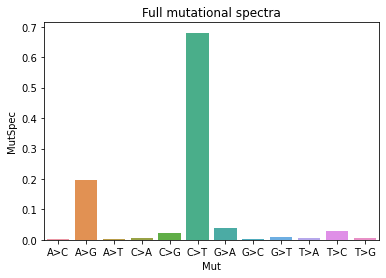

In [10]:
plot_mutspec12(ms12)

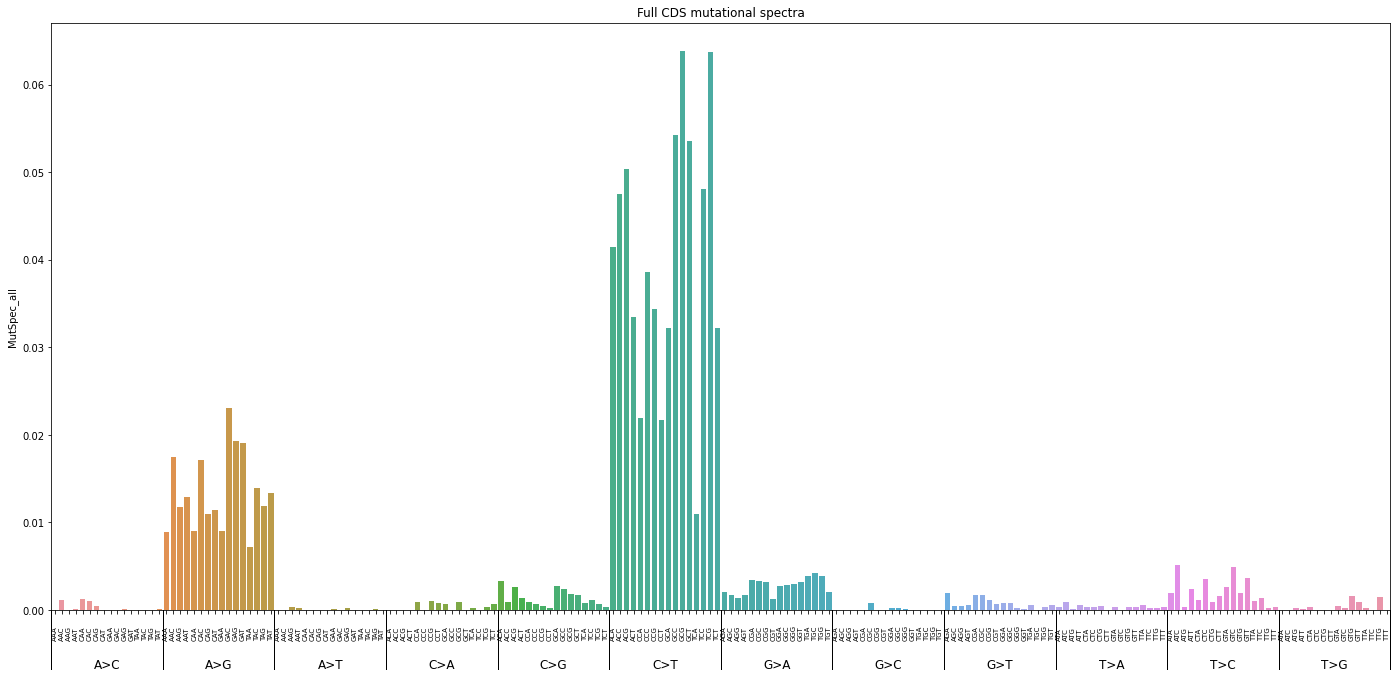

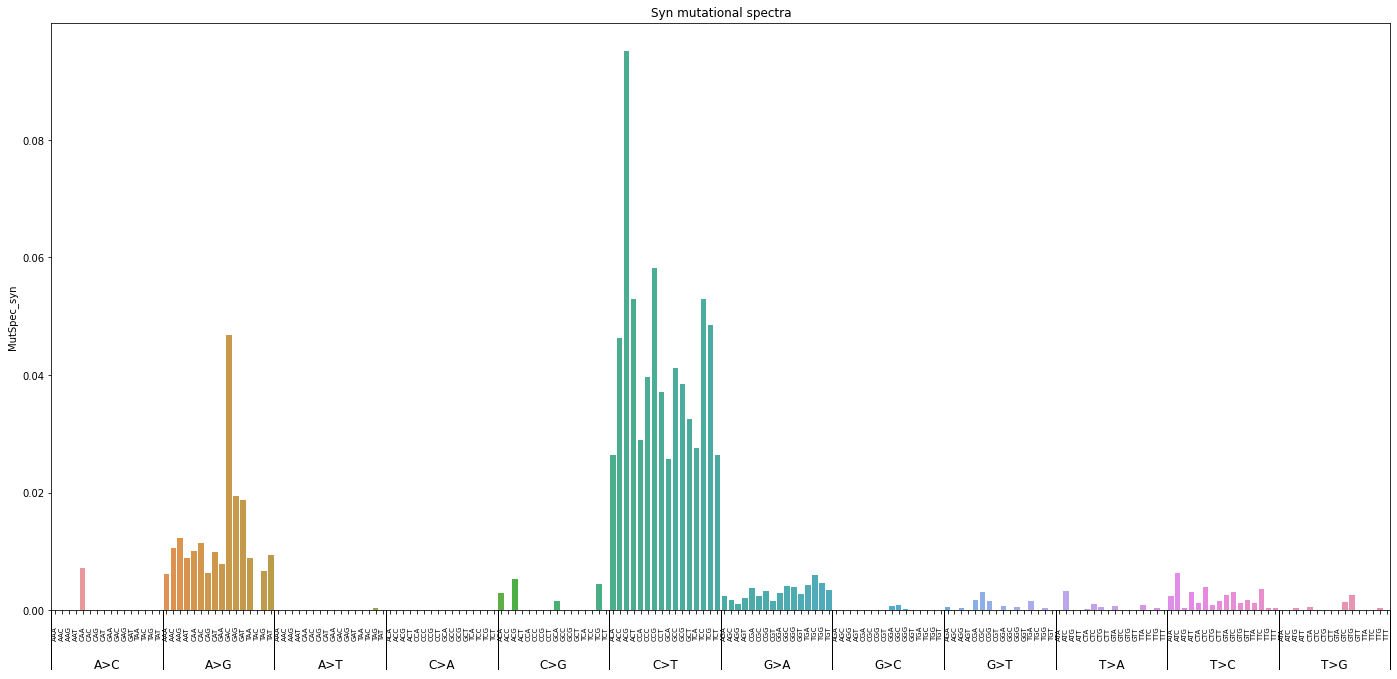

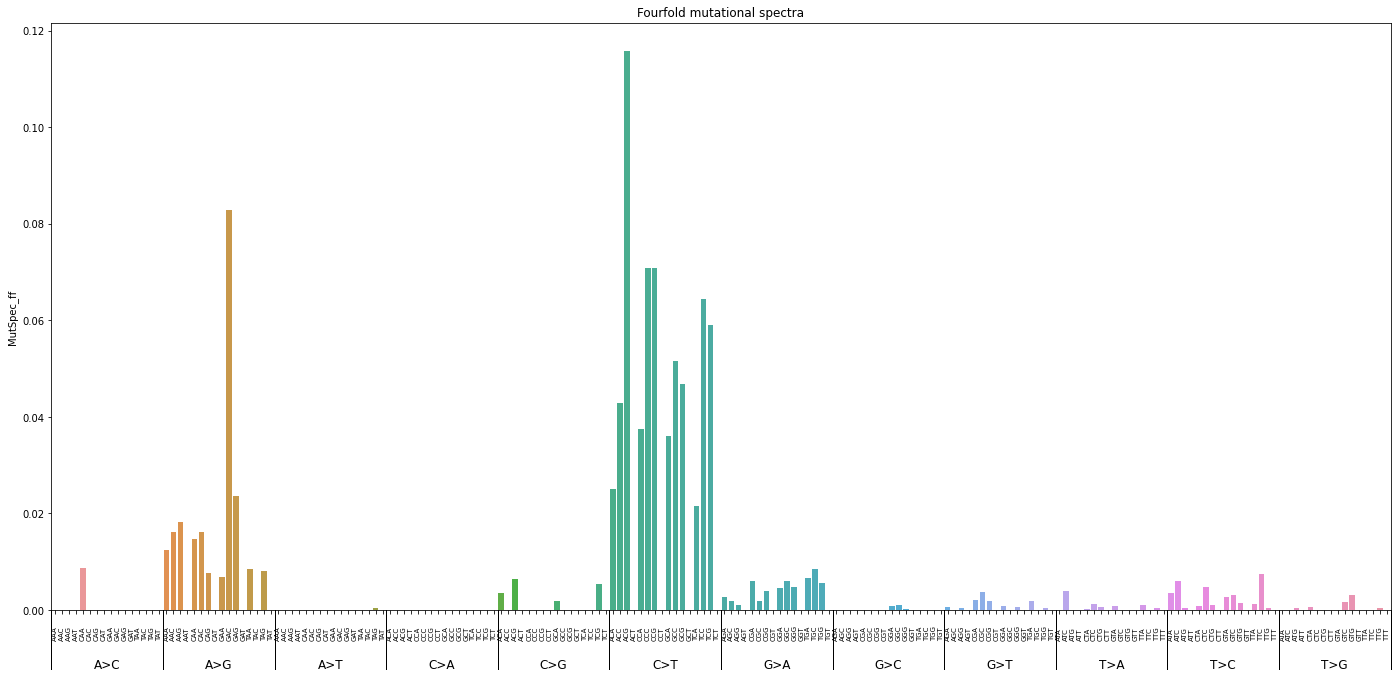

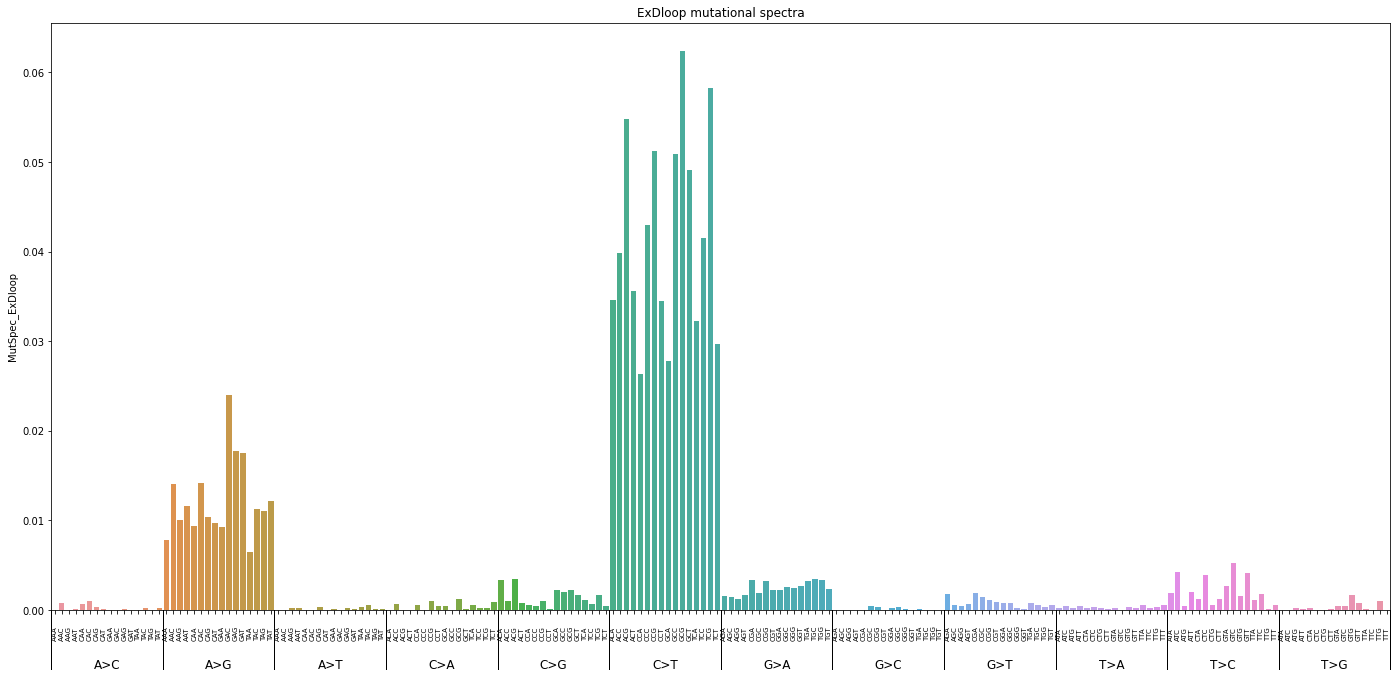

In [11]:
plot_mutspec192(mutspec192, "MutSpec_all", "Full CDS mutational spectra")
plot_mutspec192(mutspec192, "MutSpec_syn", "Syn mutational spectra")
plot_mutspec192(mutspec192, "MutSpec_ff", "Fourfold mutational spectra")
plot_mutspec192(mutspec192, "MutSpec_ExDloop", "ExDloop mutational spectra")

## Calculate similarities using hypoxia features

### Explorary features analysis

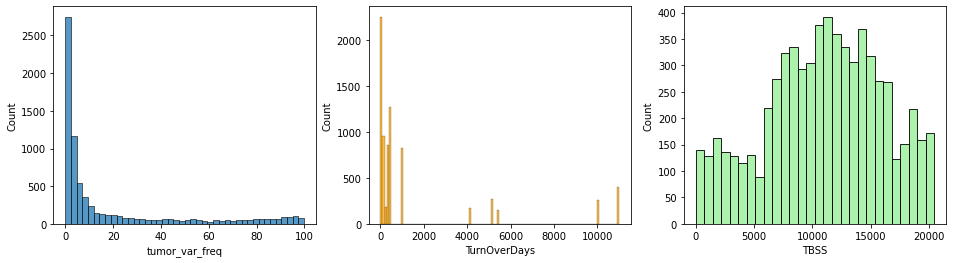

In [38]:
plt.figure(figsize=(16, 4))
plt.subplot(131)
sns.histplot(mutations["tumor_var_freq"])
plt.subplot(132)
sns.histplot(mutations["TurnOverDays"], color="orange")
plt.subplot(133)
sns.histplot(mutations["TBSS"], color="lightgreen")
plt.show()

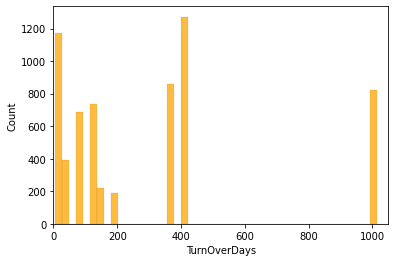

In [70]:
sns.histplot(mutations["TurnOverDays"], color="orange", bins=500, cumulative=False)
plt.xlim(0, 1050);

In [90]:
pd.DataFrame(mutations["TurnOverDays"].value_counts().sort_index()).T

,4.0,5.0,5.5,6.0,11.0,16.0,30.0,84.5,120.0,147.0,200.0,360.0,400.0,1000.0,4138.0,5143.0,5373.0,10000.0,11000.0
TurnOverDays,145,224,210,38,409,146,394,689,739,217,189,861,1273,822,168,268,155,262,402


### Add Dummy variables for hypoxia features

In [91]:
# # Looking at disributions
# mutations["DummyVAF"] = 0
# mutations.loc[(mutations.tumor_var_freq >= 5) & (mutations.tumor_var_freq < 10), "DummyVAF"] = 1
# mutations.loc[(mutations.tumor_var_freq >= 10) & (mutations.tumor_var_freq < 20), "DummyVAF"] = 2
# mutations.loc[(mutations.tumor_var_freq >= 20) & (mutations.tumor_var_freq < 50), "DummyVAF"] = 3
# mutations.loc[(mutations.tumor_var_freq >= 50) & (mutations.tumor_var_freq < 70), "DummyVAF"] = 4
# mutations.loc[(mutations.tumor_var_freq >= 70) & (mutations.tumor_var_freq < 80), "DummyVAF"] = 5
# mutations.loc[(mutations.tumor_var_freq >= 80) & (mutations.tumor_var_freq < 90), "DummyVAF"] = 6
# mutations.loc[mutations.tumor_var_freq >= 90, "DummyVAF"] = 7

# tbss_quart = mutations.TBSS.max() // 4
# print(tbss_quart)
# mutations["DummyTBSS"] = 0
# mutations.loc[(mutations.TBSS >= tbss_quart) & (mutations.TBSS < tbss_quart * 2), "DummyTBSS"] = 1
# mutations.loc[(mutations.TBSS >= tbss_quart  * 2) & (mutations.TBSS < tbss_quart * 3), "DummyTBSS"] = 2
# mutations.loc[mutations.TBSS >= tbss_quart * 3, "DummyTBSS"] = 3

# # ???
mutations["DummyTurnOver"] = 1                                                                        # Tiny
mutations.loc[(mutations.TurnOverDays >= 35) & (mutations.TurnOverDays < 250), "DummyTurnOver"] = 2   # Small
mutations.loc[(mutations.TurnOverDays > 250) & (mutations.TurnOverDays < 500), "DummyTurnOver"] = 3   # Medium
mutations.loc[mutations.TurnOverDays == 1000, "DummyTurnOver"] = 4                                    # Large
mutations.loc[(mutations.TurnOverDays > 4000) & (mutations.TurnOverDays < 6000), "DummyTurnOver"] = 5 # Huge
mutations.loc[mutations.TurnOverDays > 8000, "DummyTurnOver"] = 6                                     # Eternal

In [94]:
mutations["DummyVAF"] = 0
mutations["DummyTBSS"] = 0
prev_qval_vaf = prev_qval_tbss = 0
n = 10
for i in range(1, n + 1):
    q = i / n
    qval_vaf = mutations.tumor_var_freq.max() + 1 if q == 1 else mutations.tumor_var_freq.quantile(q)
    mutations.loc[(mutations.tumor_var_freq >= prev_qval_vaf) & (mutations.tumor_var_freq < qval_vaf), "DummyVAF"] = i
    prev_qval_vaf = qval_vaf

    qval_tbss = mutations.TBSS.max() + 1 if q == 1 else mutations.TBSS.quantile(q)
    mutations.loc[(mutations.TBSS >= prev_qval_tbss) & (mutations.TBSS < qval_tbss), "DummyTBSS"] = i
    prev_qval_tbss = qval_tbss

In [95]:
# mutations.drop([x for x in mutations.columns if x.startswith("Dummy")], axis=1, inplace=True)
mutations.DummyTurnOver.value_counts(), mutations.DummyVAF.value_counts(), mutations.DummyTBSS.value_counts()

(3    2134
 2    1834
 1    1566
 4     822
 6     664
 5     591
 Name: DummyTurnOver, dtype: int64,
 2     769
 5     765
 3     764
 7     763
 10    762
 8     761
 9     761
 6     760
 4     759
 1     747
 Name: DummyVAF, dtype: int64,
 0     1016
 3      662
 10     660
 7      660
 9      660
 5      659
 2      659
 6      659
 8      659
 4      659
 1      658
 Name: DummyTBSS, dtype: int64)

### Cossim

In [96]:
mutations[mutations.Strand == -1].Type.value_counts()

D-loop    983
tRNA      205
CDS       171
Name: Type, dtype: int64

In [97]:
MutExDloop = mutations[(mutations.Type != "D-loop") & (mutations.Label >= 0)]  # & (mutations.Strand == 1)  TODO add stop_loss...
print(mutations.shape)
print(MutExDloop.shape)

(7611, 19)
(6340, 19)


In [102]:
def cossimExDloop(mut1: pd.DataFrame, mut2: pd.DataFrame, sbs=None):
    """sbs is light chain mutation"""
    ms1 = calculate_mutspec(mut1, exp_muts192["ExDloop"], use_context=True, use_proba=False)
    ms2 = calculate_mutspec(mut2, exp_muts192["ExDloop"], use_context=True, use_proba=False)
    if isinstance(sbs, str):
        assert bool(re.fullmatch("[ACGT]>[ACGT]", sbs))
        ms1 = ms1[ms1.Mut.str.contains(sbs)]
        ms2 = ms2[ms2.Mut.str.contains(sbs)]

    sim = 1 - spatial.distance.cosine(
        ms1.sort_values("Mut")["MutSpec"].values, 
        ms2.sort_values("Mut")["MutSpec"].values,
    )
    return sim

In [32]:
# DummyTurnOver [0, 5]
# DummyVAF      [0, 3]
# DummyTBSS     [0, 3]

In [105]:
# Low TurnOver VS High TurnOver

mut1 = MutExDloop[(MutExDloop.DummyTurnOver == 1)]
mut2 = MutExDloop[(MutExDloop.DummyTurnOver == 6)]
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cossimExDloop(mut1, mut2):.3f}\n")

mut1 = MutExDloop[(MutExDloop.DummyTurnOver == 1)]
mut2 = MutExDloop[(MutExDloop.DummyTurnOver > 1)]
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cossimExDloop(mut1, mut2):.3f}\n")

mut1 count = 1305
mut2 count = 571
cossim = 0.937

mut1 count = 1305
mut2 count = 5035
cossim = 0.976



In [106]:
mut1 = MutExDloop[
    (MutExDloop.DummyTurnOver > 2) &
    (MutExDloop.DummyVAF > 1)
]
mut2 = MutExDloop[
    (MutExDloop.DummyTurnOver <= 2) &
    (MutExDloop.DummyVAF <= 1)
]
print(f"mut1 count = {mut1.shape[0]}\nmut2 count = {mut2.shape[0]}\ncossim = {cossimExDloop(mut1, mut2):.3f}\n")

mut1 count = 3205
mut2 count = 277
cossim = 0.942



## Splitting machine
Searching for the best thresholds

In [130]:
def splitting_machine(feature, mut_num_cutoff=250, sbs=None):    
    values = sorted(MutExDloop[feature].unique())
    if 0 in values:
        values = values[1:]
    matrix_bound    = np.zeros((len(values), len(values)))
    matrix_pairwise = np.zeros((len(values), len(values)))
    data = []
    for b1 in values:
        for b2 in values[::-1]:
            if b1 == b2:
                break
            mut1 = MutExDloop[(MutExDloop[feature] <= b1)]
            mut2 = MutExDloop[(MutExDloop[feature] >= b2)]
            csim = cossimExDloop(mut1, mut2, sbs)
            matrix_bound[b2-1, b1-1] = csim
            matrix_pairwise[b2-1, b1-1] = cossimExDloop(
                MutExDloop[(MutExDloop[feature] == b1)], 
                MutExDloop[(MutExDloop[feature] == b2)],
                sbs
            )
            data.append({
                "b1": b1,
                "b2": b2,
                "mut_num1": mut1.shape[0],
                "mut_num2": mut2.shape[0],
                "cossim": csim,
            })
    minval = sorted(set(matrix_bound.flatten()) | set(matrix_pairwise.flatten()))[1]

    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches((20, 8))
    fig.suptitle(feature if not isinstance(sbs, str) else feature + ", only " + sbs)
    sns.heatmap(matrix_bound, vmin=minval, vmax=1, annot=True, cmap="coolwarm", mask=matrix_bound == 0, ax=axs[0])
    axs[0].set_title("Bounds search")
    axs[0].set_xlabel("b1")
    axs[0].set_ylabel("b2")
    axs[0].set_xticks(np.arange(len(values)) + 0.5, values)
    axs[0].set_yticks(np.arange(len(values)) + 0.5, values)
    sns.heatmap(matrix_pairwise, vmin=minval, vmax=1, annot=True, cmap="coolwarm", mask=matrix_pairwise == 0, ax=axs[1])
    axs[1].set_title("Pairwise cossim")
    axs[1].set_xlabel("Group 1")
    axs[1].set_ylabel("Group 2")
    axs[1].set_xticks(np.arange(len(values)) + 0.5, values)
    axs[1].set_yticks(np.arange(len(values)) + 0.5, values)
    plt.show()
    
    df = pd.DataFrame(data).sort_values("cossim")
    df["enough_muts"] = (df.mut_num1 > mut_num_cutoff) & (df.mut_num2 > mut_num_cutoff)
    return df


def splitting_machine3d(feature1, feature2, mut_num_cutoff=250, sbs=None):
    values1 = sorted(MutExDloop[feature1].unique())
    values2 = sorted(MutExDloop[feature2].unique())
    data = []
    for b1 in values1:
        for b2 in values1[::-1]:
            if b1 == b2:
                break
            for d1 in values2:
                for d2 in values2[::-1]:
                    if d1 == d2:
                        break
                    mut1 = MutExDloop[
                        (MutExDloop[feature1] <= b1) &
                        (MutExDloop[feature2] <= d1)
                    ]
                    mut2 = MutExDloop[
                        (MutExDloop[feature1] >= b2) &
                        (MutExDloop[feature2] >= d2)
                    ]
                    csim = cossimExDloop(mut1, mut2, sbs)
                    data.append({
                        f"{feature1}_b1": b1,
                        f"{feature1}_b2": b2,
                        f"{feature2}_b1": d1,
                        f"{feature2}_b2": d2,
                        "mut_num1": mut1.shape[0],
                        "mut_num2": mut2.shape[0],
                        "cossim": csim,
                    })

    df = pd.DataFrame(data).sort_values("cossim")
    df["enough_muts"] = (df.mut_num1 > mut_num_cutoff) & (df.mut_num2 > mut_num_cutoff)
    return df

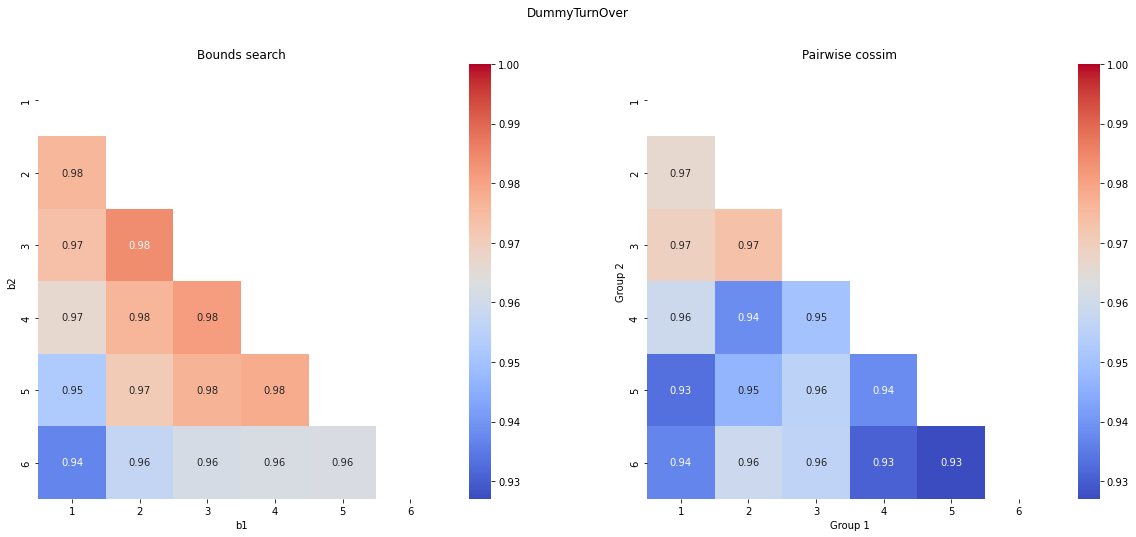

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
0,1,6,1305,571,0.936889,True
1,1,5,1305,1065,0.952612,True
5,2,6,2841,571,0.957034,True
9,3,6,4624,571,0.961372,True
12,4,6,5275,571,0.961956,True
14,5,6,5769,571,0.962112,True
2,1,4,1305,1716,0.966101,True
6,2,5,2841,1065,0.970785,True
3,1,3,1305,3499,0.973550,True
4,1,2,1305,5035,0.976015,True


In [131]:
splitting_machine("DummyTurnOver")

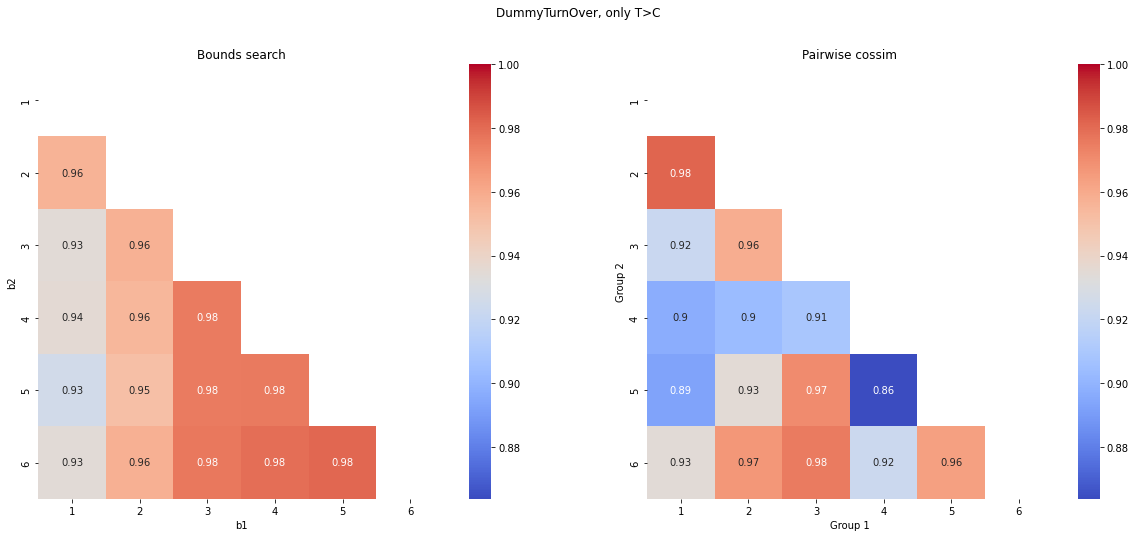

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
1,1,5,1305,1065,0.925996,True
3,1,3,1305,3499,0.934471,True
0,1,6,1305,571,0.934513,True
2,1,4,1305,1716,0.935626,True
6,2,5,2841,1065,0.951394,True
7,2,4,2841,1716,0.955043,True
4,1,2,1305,5035,0.956421,True
8,2,3,2841,3499,0.957033,True
5,2,6,2841,571,0.957505,True
10,3,5,4624,1065,0.975299,True


In [119]:
splitting_machine("DummyTurnOver", sbs="T>C")  # A>G on heavy

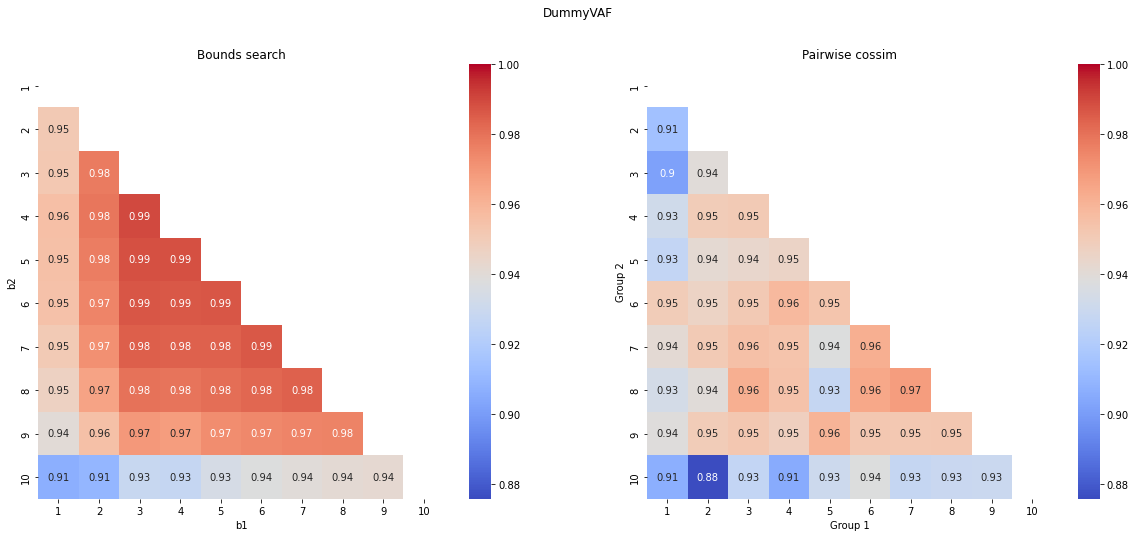

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
0,1,10,571,557,0.906893,True
9,2,10,1203,557,0.909443,True
24,4,10,2502,557,0.927497,True
17,3,10,1856,557,0.928597,True
30,5,10,3156,557,0.934085,True


In [135]:
_ = splitting_machine("DummyVAF")
_.head()

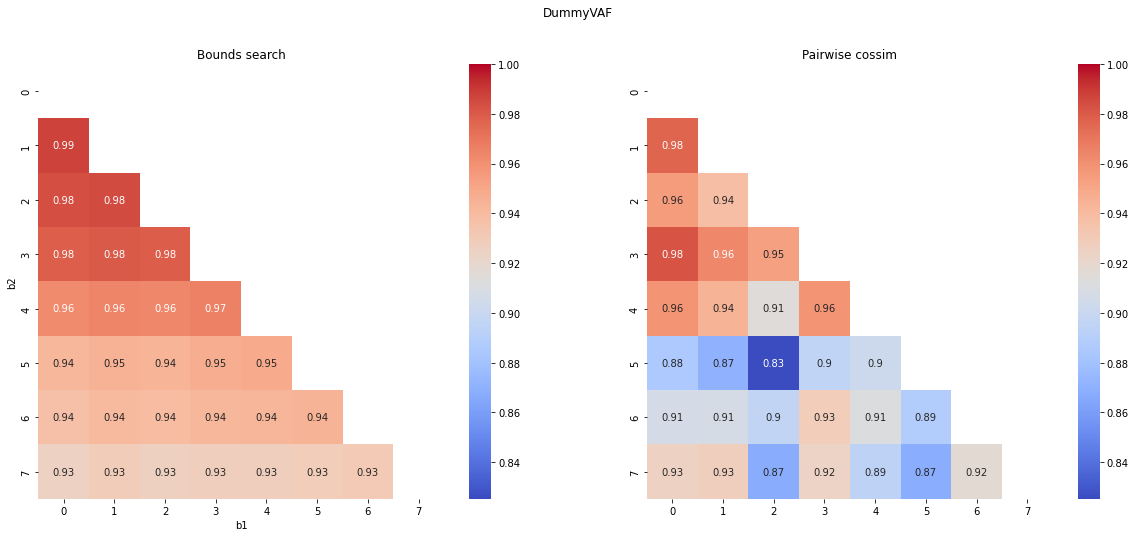

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
0,0,7,3307,275,0.925480,True
13,2,7,4656,275,0.925871,True
18,3,7,5371,275,0.927499,True
22,4,7,5691,275,0.927556,True
25,5,7,5857,275,0.928735,True
7,1,7,4109,275,0.929298,True
27,6,7,6065,275,0.930890,True
1,0,6,3307,483,0.936551,True
14,2,6,4656,483,0.939545,True
8,1,6,4109,483,0.940324,True


In [38]:
# splitting_machine("DummyVAF")  # old

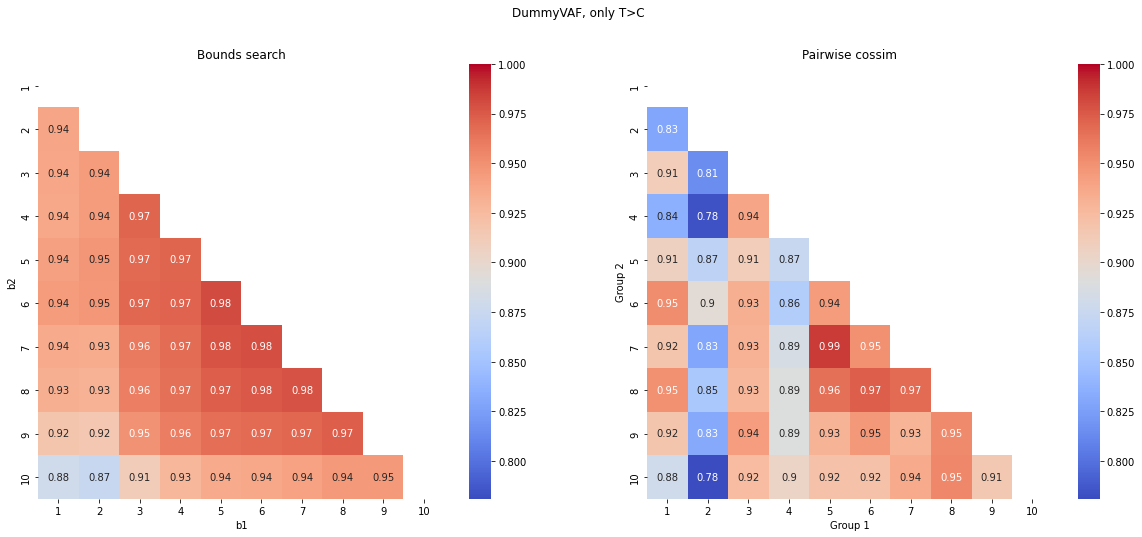

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
9,2,10,1203,557,0.873906,True
0,1,10,571,557,0.879833,True
17,3,10,1856,557,0.911336,True
10,2,9,1203,1170,0.915294,True
1,1,9,571,1170,0.917592,True


In [133]:
_ = splitting_machine("DummyVAF", sbs="T>C")
_.head()

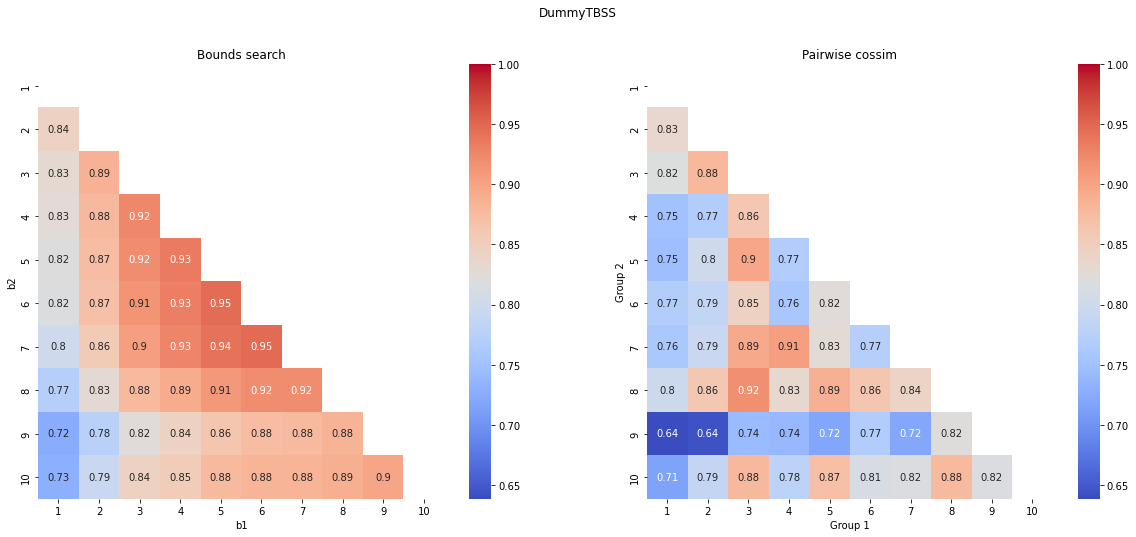

,b1,b2,mut_num1,mut_num2,cossim,enough_muts
1,1,9,632,1249,0.724799,True
0,1,10,632,607,0.727593,True
2,1,8,632,1869,0.771263,True
10,2,9,1271,1249,0.775380,True
9,2,10,1271,607,0.792931,True


In [134]:
_ = splitting_machine("DummyTBSS")
_.head()
# be carefull, mutspecs normalized on the same mutations excluding genome positioning, that is nessesary in case of TBSS

In [136]:
pair = splitting_machine3d("DummyTurnOver", "DummyVAF")
pair[pair.enough_muts].head(15)

,DummyTurnOver_b1,DummyTurnOver_b2,DummyVAF_b1,DummyVAF_b2,mut_num1,mut_num2,cossim,enough_muts
57,1,5,2,7,265,450,0.807762,True
56,1,5,2,8,265,335,0.809807,True
12,1,6,2,7,265,255,0.815394,True
58,1,5,2,6,265,560,0.821864,True
13,1,6,2,6,265,312,0.828931,True
100,1,4,2,9,265,304,0.831726,True
101,1,4,2,8,265,476,0.841873,True
102,1,4,2,7,265,663,0.850260,True
144,1,3,2,10,265,274,0.855286,True
282,2,5,2,7,540,450,0.858259,True


In [145]:
MutExDloop.loc[(MutExDloop.DummyTurnOver <= 1), "OutTurnOver"] = "Slow"
MutExDloop.loc[(MutExDloop.DummyTurnOver >= 5), "OutTurnOver"] = "High"
MutExDloop.loc[(MutExDloop.DummyVAF <= 2), "OutVAF"] = "Low"
MutExDloop.loc[(MutExDloop.DummyVAF >= 7), "OutVAF"] = "High"

In [151]:
MutExDloop.groupby(["OutTurnOver", "OutVAF"]).Mut.count()

OutTurnOver  OutVAF
High         High      450
             Low       187
Slow         High      555
             Low       750
Name: Mut, dtype: int64

In [148]:
for name, gr in MutExDloop.groupby(["OutTurnOver", "OutVAF"]):
    break

In [157]:
data = []
for to1 in MutExDloop.OutTurnOver.unique():
    if not isinstance(to1, str):
        continue
    for vaf1 in MutExDloop.OutVAF.unique():
        if not isinstance(vaf1, str):
            continue
        for to2 in MutExDloop.OutTurnOver.unique():
            if not isinstance(to2, str):
                continue
            for vaf2 in MutExDloop.OutVAF.unique():
                if not isinstance(vaf2, str):
                    continue
                sim = cossimExDloop(
                    MutExDloop[(MutExDloop.OutTurnOver == to1) & (MutExDloop.OutVAF == vaf1)],
                    MutExDloop[(MutExDloop.OutTurnOver == to2) & (MutExDloop.OutVAF == vaf2)],
                )
                one_data = {
                    "TurnOver1": to1,
                    "VAF1": vaf1,
                    "TurnOver2": to2,
                    "VAF2": vaf2,
                    "cossim": sim,
                }
                data.append(one_data)
                # if sim != 1:
                #     print(f"mut1: TurnOver={to1}, VAF={vaf1}\nmut2: TurnOver={to2}, VAF={vaf2}\nCossim={sim}\n\n")

In [159]:
df = pd.DataFrame(data)
df

,TurnOver1,VAF1,TurnOver2,VAF2,cossim
0,Slow,High,Slow,High,1.000000
1,Slow,High,Slow,Low,0.951260
2,Slow,High,High,High,0.896873
3,Slow,High,High,Low,0.819216
4,Slow,Low,Slow,High,0.951260
5,Slow,Low,Slow,Low,1.000000
6,Slow,Low,High,High,0.889902
7,Slow,Low,High,Low,0.802340
8,High,High,Slow,High,0.896873
9,High,High,Slow,Low,0.889902


In [160]:
df.pivot(["TurnOver1", "VAF1"], ["TurnOver2", "VAF2"], "cossim")

TurnOver2           Slow                High          
VAF2                High       Low      High       Low
TurnOver1 VAF1                                        
High      High  0.896873  0.889902  1.000000  0.848023
          Low   0.819216  0.802340  0.848023  1.000000
Slow      High  1.000000  0.951260  0.896873  0.819216
          Low   0.951260  1.000000  0.889902  0.802340

In [43]:
def sample_mutations(mutations: pd.DataFrame, method="bootstrap"):
    """bootstrap vs permutations"""
    if method == "bootstrap":
        mutations = mutations.sample(mutations.shape[0], replace=True)
    elif method == "permutations":
        raise NotImplementedError()
    else:
        raise ValueError("Pass appropriate method: 'bootstrap' or 'permutations'")
    return mutations
    

def compare_signuficantly(mutations: pd.DataFrame, feature: str, b1, b2, sbs=None, niters=5000, method="bootstrap", mode="one-tailed"):
    """
    бутстрепнутые выборки более случайны, а значит более непохожие, поэтому можно брать one-tailed, 
    ведь обратное маловероятно
    """
    cossims = []
    mut1 = mutations[(mutations[feature] <= b1)]
    mut2 = mutations[(mutations[feature] >= b2)]
    true_csim = cossimExDloop(mut1, mut2, sbs)

    for _ in range(niters):
        mut_sample = sample_mutations(mutations, method=method)
        mut1 = mut_sample[(mut_sample[feature] <= b1)]
        mut2 = mut_sample[(mut_sample[feature] >= b2)]
        csim = cossimExDloop(mut1, mut2, sbs)
        cossims.append(csim)

    cossims = np.array(cossims)
    p1 = (cossims > true_csim).sum() / niters
    if mode == "two-tailed":
        p2 = (cossims < (cossims.mean() * 2 - true_csim)).sum() / niters
    elif mode == "one-tailed":
        p2 = 0
    pvalue = p1 + p2
    return true_csim, pvalue, cossims


def compare_signuficantly_2fea(mutations: pd.DataFrame, feature1, feature2, f1b1, f1b2, f2b1, f2b2, sbs=None, niters=5000, method="bootstrap", mode="one-tailed"):
    cossims = []
    mut1 = mutations[
        (mutations[feature1] <= f1b1) &
        (mutations[feature2] <= f2b1)
    ]
    mut2 = mutations[
        (mutations[feature1] >= f1b2) &
        (mutations[feature2] >= f2b2)
    ]
    true_csim = cossimExDloop(mut1, mut2, sbs)

    for _ in range(niters):
        mut_sample = sample_mutations(mutations, method=method)
        mut1 = mut_sample[
            (mut_sample[feature1] <= f1b1) &
            (mut_sample[feature2] <= f2b1)
        ]
        mut2 = mut_sample[
            (mut_sample[feature1] >= f1b2) &
            (mut_sample[feature2] >= f2b2)
        ]
        csim = cossimExDloop(mut1, mut2, sbs)
        cossims.append(csim)

    cossims = np.array(cossims)
    p1 = (cossims > true_csim).sum() / niters
    if mode == "two-tailed":
        p2 = (cossims < (cossims.mean() * 2 - true_csim)).sum() / niters
    elif mode == "one-tailed":
        p2 = 0
    pvalue = p1 + p2
    return true_csim, pvalue, cossims

In [44]:
true_csim, pvalue, cossims = compare_signuficantly(MutExDloop, "DummyTurnOver", 0, 5, niters=3000)
true_csim, pvalue

(0.9369251196869489, 0.019333333333333334)

In [45]:
true_csim, pvalue, cossims = compare_signuficantly(MutExDloop, "DummyTurnOver", 0, 4, niters=5000)
true_csim, pvalue

(0.9525835280472803, 0.0262)

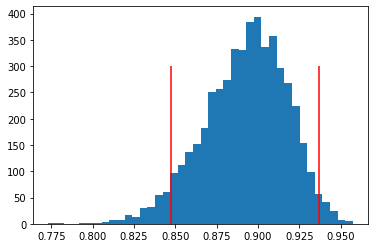

In [123]:
plt.hist(cossims, bins=40)
plt.vlines([true_csim, cossims.mean() * 2 - true_csim], 0, 300, 'r')

In [46]:
true_csim, pvalue, cossims = compare_signuficantly(MutExDloop, "DummyVAF", 0, 7, niters=2000)
true_csim, pvalue

(0.9254796182674041, 0.009)

In [47]:
true_csim, pvalue, cossims = compare_signuficantly(MutExDloop, "DummyVAF", 2, 7, niters=2000)
true_csim, pvalue

(0.9258713069328847, 0.0115)

In [48]:
true_csim, pvalue, cossims = compare_signuficantly_2fea(MutExDloop, "DummyVAF", "DummyTurnOver", 1, 4, 0, 3, niters=2000)
true_csim, pvalue

(0.8633848623330866, 0.035)

In [49]:
true_csim, pvalue, cossims = compare_signuficantly_2fea(MutExDloop, "DummyVAF", "DummyTurnOver", 0, 4, 0, 3, niters=2000)
true_csim, pvalue

(0.8547415188326101, 0.0485)

## Plan

1. (done) VAF & TurnOver trashholds machine
2. (done) Compare only A>G 
3. (done) pvalue
4. context for TBSS (optional)

aaaaaaaaaa

1. add pval to all
2. (done) use deciles
